# Supplementary Paper Scenarios

This notebook runs the scenarios used in the paper's Supplementary Information.

Developed by Siobhan Powell, 2021.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import numpy as np
import pickle
import time

In [3]:
from speech_classes import SPEECh
from speech_classes import SPEEChGeneralConfiguration
from speech_classes import LoadProfile
from speech_classes import Plotting
from speech_classes import DataSetConfigurations

## Number of Home Chargers in each scenario: 

In [12]:
home_chargers = pd.DataFrame(np.zeros((4, 11)), index=['UniversalHome', 'HighHome', 'LowHome_HighWork', 'LowHome_LowWork'], columns=['CA', 'OR', 'WA', 'ID', 'MT', 'WY', 'NV', 'UT', 'CO', 'NM', 'AZ'])
for scenario_name in ['UniversalHome', 'HighHome', 'LowHome_HighWork', 'LowHome_LowWork']:
    print(scenario_name)
    for state in ['CA', 'OR', 'WA', 'ID', 'MT', 'WY', 'NV', 'UT', 'CO', 'NM', 'AZ']:

        data = DataSetConfigurations(data_set='CP')
        speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=[state])
        speech.pa_ih(scenario=scenario_name)
        speech.pg_multiple_regions(region_type='State', region_value_list=[state])
        
        tot = 0
        for key in speech.p_abe_data.index:
            if 'home_l2' in key:
                tot += speech.p_abe_data.loc[key, 'p_abe']
                
        home_chargers.loc[scenario_name, state] = tot * speech.num_evs

UniversalHome
HighHome
LowHome_HighWork
LowHome_LowWork


In [13]:
home_chargers

,CA,OR,WA,ID,MT,WY,NV,UT,CO,NM,AZ
UniversalHome,1.835599e+07,2.228924e+06,3.944631e+06,1.086276e+06,631014.806368,354441.753963,1.457896e+06,1.563567e+06,3.215941e+06,951040.267476,2.457641e+06
HighHome,1.464512e+07,1.785327e+06,3.120881e+06,8.612021e+05,503724.209642,285981.476638,1.178376e+06,1.253821e+06,2.564097e+06,756650.055222,1.943663e+06
LowHome_HighWork,5.372737e+06,6.572175e+05,1.139926e+06,3.133962e+05,185391.058550,104924.796922,4.306676e+05,4.617697e+05,9.361265e+05,275714.629461,7.082449e+05
LowHome_LowWork,5.372737e+06,6.572175e+05,1.139926e+06,3.133962e+05,185391.058550,104924.796922,4.306676e+05,4.617697e+05,9.361265e+05,275714.629461,7.082449e+05


In [14]:
home_chargers['Total'] = home_chargers.sum(axis=1)
home_chargers['Total']

UniversalHome       3.624737e+07
HighHome            2.889884e+07
LowHome_HighWork    1.058612e+07
LowHome_LowWork     1.058612e+07
Name: Total, dtype: float64

## Large Battery Case

In [4]:
def run_100p_wecc_largebattery(scenario_name, remove_timers, utility_region, save_string, date):
    
    for weekday_string in ['weekday', 'weekend']:

        wecc_tot_evs = 0
        state_list = ['CA', 'OR', 'WA', 'ID', 'MT', 'WY', 'NV', 'UT', 'CO', 'NM', 'AZ']
        state_results = {}
        total_load_dict = {key:np.zeros((1440,)) for key in ['Residential L1', 'Residential L2', 'MUD L2', 'Workplace L2', 'Public L2', 'Public DCFC']}
        total_load_segments = np.zeros((1440, 6))
        for state in state_list:
            print('----------'+state+'----------')
            data = DataSetConfigurations(data_set='CP')
            speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=[state])
            speech.pa_ih(scenario=scenario_name)

            # Large Batteries Only:
            speech.pb_i(scenario='Equal')
            
            speech.pg_multiple_regions(region_type='State', region_value_list=[state])
            config = SPEEChGeneralConfiguration(speech, remove_timers=remove_timers, utility_region=utility_region)
            config.run_all(verbose=False, weekday=weekday_string)
            state_results[state] = {'Speech':speech, 'Config':config}
            for key in total_load_dict.keys():
                total_load_dict[key] += config.total_load_dict[key]
            total_load_segments += config.total_load_segments
            print('Total EVs: ', config.num_total_drivers)
            wecc_tot_evs += config.num_total_drivers
            if weekday_string == 'weekday':
                pd.DataFrame(config.total_load_dict).to_csv('Outputs/Supplement/'+save_string+'_'+str(state)+'_'+date+'.csv')
            else:
                pd.DataFrame(config.total_load_dict).to_csv('Outputs/Supplement/'+save_string+'_weekend_'+str(state)+'_'+date+'.csv')
        if weekday_string == 'weekday':
            pd.DataFrame(total_load_dict).to_csv('Outputs/Supplement/'+save_string+'_WECC_'+date+'.csv')
        else:
            pd.DataFrame(total_load_dict).to_csv('Outputs/Supplement/'+save_string+'_weekend_WECC_'+date+'.csv')
        print('Total EVs in WECC: ', wecc_tot_evs)
    
    return

In [5]:
date = '20211119'
run_100p_wecc_largebattery('UniversalHome', True, 'PGE', 'UniversalHome_LargeBatteryOnly_100p_NoTimers', date)
run_100p_wecc_largebattery('HighHome', True, 'PGE', 'HighHome_LargeBatteryOnly_100p_NoTimers', date)
run_100p_wecc_largebattery('LowHome_HighWork', True, 'PGE', 'LowHome_HighWork_LargeBatteryOnly_100p_NoTimers', date)
run_100p_wecc_largebattery('LowHome_LowWork', True, 'PGE', 'LowHome_LowWork_LargeBatteryOnly_100p_NoTimers', date)

----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
Total EVs in WECC:  48640772
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
Total EVs in WECC:  4864077

/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:425: RuntimeWarning: covariance is not positive-semidefinite.
  for (mean, covariance, sample) in zip(


Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
Total EVs in WECC:  48640772
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
Total EVs in WECC:  48640772
----------CA---------

## Fast Charging Case

In [6]:
data = DataSetConfigurations(data_set='CP')
speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=['OR'])
speech.pa_ih(scenario='HighHome')
speech.pg_multiple_regions(region_type='State', region_value_list=['OR'])
config = SPEEChGeneralConfiguration(speech, remove_timers=True, utility_region='PGE')

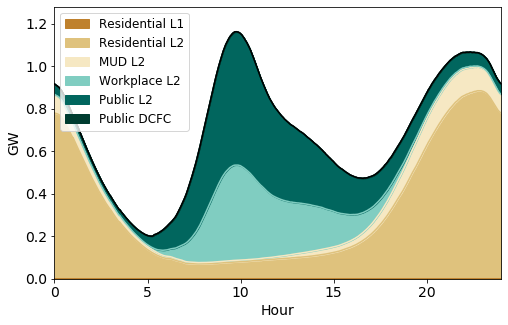

In [7]:
config.run_all(verbose=False, weekday='weekday')
plots = Plotting(speech, config)
plots.plot_single(config.total_load_segments, config.total_load_dict, save_str=None)

In [8]:
import copy

In [9]:
data = DataSetConfigurations(data_set='CP')
speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=['OR'])
speech.pa_ih(scenario='HighHome')

speech.pg_multiple_regions(region_type='State', region_value_list=['OR'])
config = SPEEChGeneralConfiguration(speech, remove_timers=True, utility_region='PGE')

for g in range(data.ng):
    for weekday in ['weekday', 'weekend']:
        config.group_configs[g].segment_session_numbers[weekday]['public_l3'] += config.group_configs[g].segment_session_numbers[weekday]['public_l2']
        config.group_configs[g].segment_session_numbers[weekday]['public_l2'] = 0
        if config.group_configs[g].segment_session_numbers[weekday]['public_l3'] > 0:
            if 'public_l3' not in config.group_configs[g].segment_gmms[weekday].keys():
                # copy gmm from another group that has most fast charging within the same energy bin
                if g <= 20:
                    target_g = 11
                elif g <= 34:
                    target_g = 27
                elif g <= 48:
                    target_g = 41
                elif g <= 68:
                    target_g = 55
                elif g <= 93:
                    target_g = 71
                elif g <= 114:
                    target_g = 94
                else:
                    target_g = 115
                config.group_configs[g].segment_gmms[weekday]['public_l3'] = copy.deepcopy(config.group_configs[target_g].segment_gmms[weekday]['public_l3'])
            

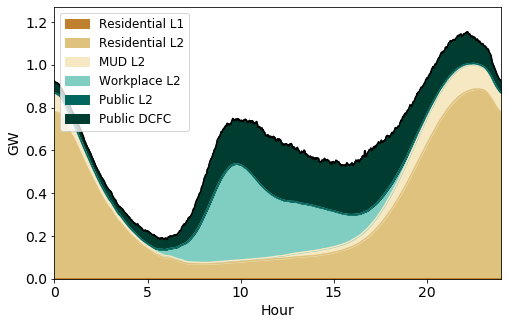

In [10]:
config.run_all(verbose=False, weekday='weekday')
plots = Plotting(speech, config)
plots.plot_single(config.total_load_segments, config.total_load_dict, save_str=None)

In [11]:
def run_100p_wecc_fastcharging(scenario_name, remove_timers, utility_region, save_string, date):
    
    for weekday_string in ['weekday', 'weekend']:

        wecc_tot_evs = 0
        state_list = ['CA', 'OR', 'WA', 'ID', 'MT', 'WY', 'NV', 'UT', 'CO', 'NM', 'AZ']
        state_results = {}
        total_load_dict = {key:np.zeros((1440,)) for key in ['Residential L1', 'Residential L2', 'MUD L2', 'Workplace L2', 'Public L2', 'Public DCFC']}
        total_load_segments = np.zeros((1440, 6))
        for state in state_list:
            print('----------'+state+'----------')
            data = DataSetConfigurations(data_set='CP')
            speech = SPEECh(data=data, penetration_level=1.0, outside_california=True, states=[state])
            speech.pa_ih(scenario=scenario_name)
            
            speech.pg_multiple_regions(region_type='State', region_value_list=[state])
            config = SPEEChGeneralConfiguration(speech, remove_timers=remove_timers, utility_region=utility_region)

            # switch public l2 to fast charging
            for g in range(data.ng):
                for weekday in ['weekday', 'weekend']:
                    config.group_configs[g].segment_session_numbers[weekday]['public_l3'] += config.group_configs[g].segment_session_numbers[weekday]['public_l2']
                    config.group_configs[g].segment_session_numbers[weekday]['public_l2'] = 0
                    if config.group_configs[g].segment_session_numbers[weekday]['public_l3'] > 0:
                        if 'public_l3' not in config.group_configs[g].segment_gmms[weekday].keys():
                            # copy gmm from another group that has most fast charging within the same energy bin
                            if g <= 20:
                                target_g = 11
                            elif g <= 34:
                                target_g = 27
                            elif g <= 48:
                                target_g = 41
                            elif g <= 68:
                                target_g = 55
                            elif g <= 93:
                                target_g = 71
                            elif g <= 114:
                                target_g = 94
                            else:
                                target_g = 115
                            config.group_configs[g].segment_gmms[weekday]['public_l3'] = copy.deepcopy(config.group_configs[target_g].segment_gmms[weekday]['public_l3'])

            config.run_all(verbose=False, weekday=weekday_string)
            state_results[state] = {'Speech':speech, 'Config':config}
            for key in total_load_dict.keys():
                total_load_dict[key] += config.total_load_dict[key]
            total_load_segments += config.total_load_segments
            print('Total EVs: ', config.num_total_drivers)
            wecc_tot_evs += config.num_total_drivers
            if weekday_string == 'weekday':
                pd.DataFrame(config.total_load_dict).to_csv('Outputs/Supplement/'+save_string+'_'+str(state)+'_'+date+'.csv')
            else:
                pd.DataFrame(config.total_load_dict).to_csv('Outputs/Supplement/'+save_string+'_weekend_'+str(state)+'_'+date+'.csv')
        if weekday_string == 'weekday':
            pd.DataFrame(total_load_dict).to_csv('Outputs/Supplement/'+save_string+'_WECC_'+date+'.csv')
        else:
            pd.DataFrame(total_load_dict).to_csv('Outputs/Supplement/'+save_string+'_weekend_WECC_'+date+'.csv')
        print('Total EVs in WECC: ', wecc_tot_evs)
    
    return

In [12]:
date = '20211119'
run_100p_wecc_fastcharging('UniversalHome', True, 'PGE', 'UniversalHome_FastCharging_100p_NoTimers', date)
run_100p_wecc_fastcharging('HighHome', True, 'PGE', 'HighHome_FastCharging_100p_NoTimers', date)
run_100p_wecc_fastcharging('LowHome_HighWork', True, 'PGE', 'LowHome_HighWork_FastCharging_100p_NoTimers', date)
run_100p_wecc_fastcharging('LowHome_LowWork', True, 'PGE', 'LowHome_LowWork_FastCharging_100p_NoTimers', date)

----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
Total EVs in WECC:  48640772
----------CA----------
Total EVs:  24234832
----------OR----------
Total EVs:  2923172
----------WA----------
Total EVs:  5280998
----------ID----------
Total EVs:  1269502
----------MT----------
Total EVs:  863108
----------WY----------
Total EVs:  478703
----------NV----------
Total EVs:  1879178
----------UT----------
Total EVs:  1951222
----------CO----------
Total EVs:  3977177
----------NM----------
Total EVs:  1407939
----------AZ----------
Total EVs:  4374941
Total EVs in WECC:  4864077